In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

%matplotlib inline

/Users/alex/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
data = pd.read_csv('Data/all_team_data_1980-2020.csv', index_col = 'id').drop('Unnamed: 0', axis = 1)

In [3]:
data.columns

Index(['abbreviation', 'assists', 'blocks', 'defensive_rebounds',
       'field_goal_attempts', 'field_goal_percentage', 'field_goals',
       'free_throw_attempts', 'free_throw_percentage', 'free_throws',
       'games_played', 'minutes_played', 'name', 'offensive_rebounds',
       'opp_assists', 'opp_blocks', 'opp_defensive_rebounds',
       'opp_field_goal_attempts', 'opp_field_goal_percentage',
       'opp_field_goals', 'opp_free_throw_attempts',
       'opp_free_throw_percentage', 'opp_free_throws',
       'opp_offensive_rebounds', 'opp_personal_fouls', 'opp_points',
       'opp_steals', 'opp_three_point_field_goal_attempts',
       'opp_three_point_field_goal_percentage', 'opp_three_point_field_goals',
       'opp_total_rebounds', 'opp_turnovers',
       'opp_two_point_field_goal_attempts',
       'opp_two_point_field_goal_percentage', 'opp_two_point_field_goals',
       'personal_fouls', 'points', 'rank', 'steals',
       'three_point_field_goal_attempts', 'three_point_field_goa

In [4]:
data['MOV'] = [(points - opp_points) / games for points, opp_points, games in zip(data['points'],
                                                                                      data['opp_points'],
                                                                                      data['games'])]
data['adj_win_rate'] = [wins / games - 0.5 for wins, games in zip(data['wins'], data['games'])]
data['win_rate'] = [wins / games for wins, games in zip(data['wins'], data['games'])]

In [5]:
X = pd.DataFrame(data['MOV'])
X['intercept'] = [1 for x in range(data.shape[0])]
y = data['win_rate']

In [6]:
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               win_rate   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 1.817e+04
Date:                Thu, 23 Apr 2020   Prob (F-statistic):               0.00
Time:                        15:46:59   Log-Likelihood:                 2114.8
No. Observations:                1134   AIC:                            -4226.
Df Residuals:                    1132   BIC:                            -4215.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MOV            0.0324      0.000    134.780      0.000       0.032       0.033
intercept      0.5000      0.001    448.789      0.000       0.498       0.502
==============================================================================
Omnibus:                        0.365   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.833   Jarque-Bera (JB):                0.450
Skew:                          -0.008   Prob(JB):                        0.799
Kurtosis:                       2.904   Cond. No.                         4.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
preds = fit.predict(X)

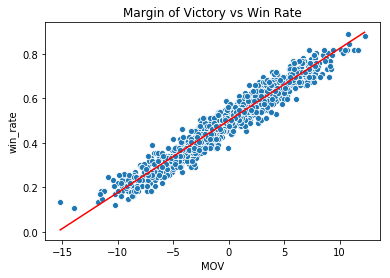

In [8]:
sns.scatterplot(x = X['MOV'], y = y)
sns.lineplot(x = X['MOV'], y = preds, color = 'red')
plt.title('Margin of Victory vs Win Rate');

In [9]:
def mae(predictions, actuals):
    sae = 0
    for pred, act in zip(predictions, actuals):
        sae += abs(pred - act)
    return sae / len(predictions)

In [10]:
mae(preds, y)

0.030059353044350125

In [11]:
results = pd.DataFrame({'id': data.index, 'MOV': data['MOV'], 'actual': data['win_rate'], 'prediction': preds})

# Positive Error for overachievers, negative error for underachievers
results['error'] = [act - pred for act, pred in zip(results['actual'], results['prediction'])]

merge_cols = ['wins', 'games', 'playoff_wins', 'playoff_games']

results = pd.merge(left = results, right = data[merge_cols], how = 'inner', right_index = True, left_index = True)

results['predicted_wins'] = [int(round((prediction) * games, 0)) for prediction,
                             games in zip(results['prediction'], results['games'])]

results['game_error'] = [wins - pwins for wins, pwins in zip(results['wins'], results['predicted_wins'])]

In [12]:
mae(results['predicted_wins'], results['wins'])

2.4038800705467374

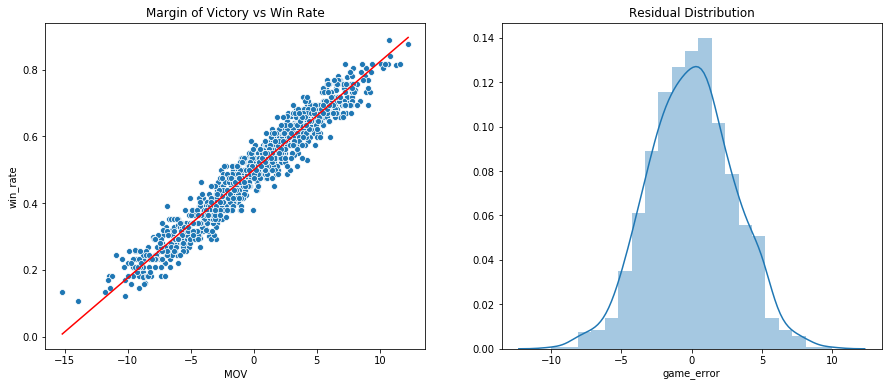

In [13]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.scatterplot(x = X['MOV'], y = y)
sns.lineplot(x = X['MOV'], y = preds, color = 'red')
plt.title('Margin of Victory vs Win Rate')

plt.subplot(1,2,2)
sns.distplot(results['game_error'], bins = 21)
plt.title('Residual Distribution');

In [14]:
overachievers = results.sort_values(by = 'error', ascending = False).head(10)
underachievers = results.sort_values(by = 'error').head(10)

In [15]:
overachievers

,id,MOV,actual,prediction,error,wins,games,playoff_wins,playoff_games,predicted_wins,game_error
id,,,,,,,,,,,
DAL 1993,DAL 1993,-15.195122,0.134146,0.008064,0.126082,11,82,0,0,1,10
LAC 1986,LAC 1986,-6.926829,0.390244,0.275748,0.114496,32,82,0,0,23,9
MIA 1992,MIA 1992,-4.207317,0.463415,0.363791,0.099624,38,82,0,3,30,8
CHH 1997,CHH 1997,1.865854,0.658537,0.560408,0.098128,54,82,0,3,46,8
DEN 1991,DEN 1991,-10.914634,0.243902,0.146643,0.097259,20,82,0,0,12,8
NYK 1997,NYK 1997,3.121951,0.695122,0.601074,0.094048,57,82,6,10,49,8
PHO 1995,PHO 1995,3.878049,0.719512,0.625552,0.093960,59,82,6,10,51,8
LAL 1995,LAL 1995,-0.219512,0.585366,0.492895,0.092471,48,82,5,10,40,8
GSW 1987,GSW 1987,-2.341463,0.512195,0.424197,0.087998,42,82,4,10,35,7


In [16]:
underachievers

,id,MOV,actual,prediction,error,wins,games,playoff_wins,playoff_games,predicted_wins,game_error
id,,,,,,,,,,,
SEA 1986,SEA 1986,-0.097561,0.378049,0.496843,-0.118794,31,82,0,0,41,-10
DAL 2018,DAL 2018,-3.036585,0.292683,0.401693,-0.109010,24,82,0,0,33,-9
PHI 2012,PHI 2012,4.242424,0.530303,0.637349,-0.107046,35,66,7,13,42,-7
DET 1998,DET 1998,1.573171,0.451220,0.550933,-0.099713,37,82,0,0,45,-8
DAL 2020,DAL 2020,6.044776,0.597015,0.695700,-0.098685,40,67,0,0,47,-7
MIN 2014,MIN 2014,2.670732,0.487805,0.586466,-0.098661,40,82,0,0,48,-8
POR 1985,POR 1985,3.402439,0.512195,0.610155,-0.097960,42,82,4,9,50,-8
MIL 1986,MIL 1986,9.036585,0.695122,0.792559,-0.097437,57,82,7,14,65,-8
BOS 2007,BOS 2007,-3.414634,0.292683,0.389454,-0.096771,24,82,0,0,32,-8


In [17]:
from sportsreference.nba.schedule import Schedule

In [18]:
# for game in Schedule('DAL', year = 1993):
#     print(game.date)  # Prints the date the game was played
#     print(game.result)  # Prints whether the team won or lost

In [19]:
dal_1993 = Schedule('DAL', year = 1993).dataframe

dal_1993['MOV'] = [points - opp_points for points, opp_points in zip(dal_1993['points_scored'], dal_1993['points_allowed'])]

In [20]:
min(dal_1993['MOV'])

-58

In [21]:
dal_1993[dal_1993['MOV'] == -58]

,boxscore_index,date,datetime,game,location,losses,opponent_abbr,opponent_name,playoffs,points_allowed,points_scored,result,streak,time,wins,MOV
199212290SAC,199212290SAC,"Tue, Dec 29, 1992",1992-12-29,23,Away,21,SAC,Sacramento Kings,False,139,81,Loss,L 6,,2,-58


In [22]:
dal_1993[dal_1993['MOV'] < -20].shape

(26, 16)

In [23]:
# from sportsreference.nba.boxscore import Boxscore

# Boxscore('199212290SAC').dataframe

### Logistic Model

Problem with the original regression is that it is linear and predicting a rate. Theoretically it is impossible to have a win rate less than 0 or greater than 1. Re-create model with a logistic regression.

In [24]:
# leave x as is
# convert y to logit of regular win rate

In [25]:
def logit(p):
    return np.log(p/(1-p))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [26]:
X = pd.DataFrame(data['MOV'])
X['intercept'] = [1 for x in range(data.shape[0])]
y = data['win_rate'].apply(logit)

In [27]:
# shouldn't need an intercept here since MOV = 0 should produce win rate of about 50%

model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               win_rate   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                 1.788e+04
Date:                Thu, 23 Apr 2020   Prob (F-statistic):               0.00
Time:                        15:47:07   Log-Likelihood:                 432.81
No. Observations:                1134   AIC:                            -861.6
Df Residuals:                    1132   BIC:                            -851.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MOV            0.1415      0.001    133.712      0.000       0.139       0.144
intercept     -0.0049      0.005     -0.989      0.323      -0.014       0.005
==============================================================================
Omnibus:                        1.747   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.417   Jarque-Bera (JB):                1.632
Skew:                          -0.061   Prob(JB):                        0.442
Kurtosis:                       3.140   Cond. No.                         4.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
preds = [sigmoid(x) for x in fit.predict(X)]

In [29]:
mae(preds, y.apply(sigmoid))

0.02911528113373538

In [30]:
from sklearn.metrics import r2_score

r2_score(y.apply(sigmoid), preds)

0.9443574450534473

In [31]:
results = pd.DataFrame({'id': data.index, 'MOV': data['MOV'], 'actual': data['win_rate'], 'prediction': preds})

# Positive Error for overachievers, negative error for underachievers
results['error'] = [act - pred for act, pred in zip(results['actual'], results['prediction'])]

merge_cols = ['wins', 'games', 'playoff_wins', 'playoff_games']

results = pd.merge(left = results, right = data[merge_cols], how = 'inner', right_index = True, left_index = True)

results['predicted_wins'] = [int(round((prediction) * games, 0)) for prediction,
                             games in zip(results['prediction'], results['games'])]

results['game_error'] = [wins - pwins for wins, pwins in zip(results['wins'], results['predicted_wins'])]

In [32]:
mae(results['predicted_wins'], results['wins'])

2.314814814814815

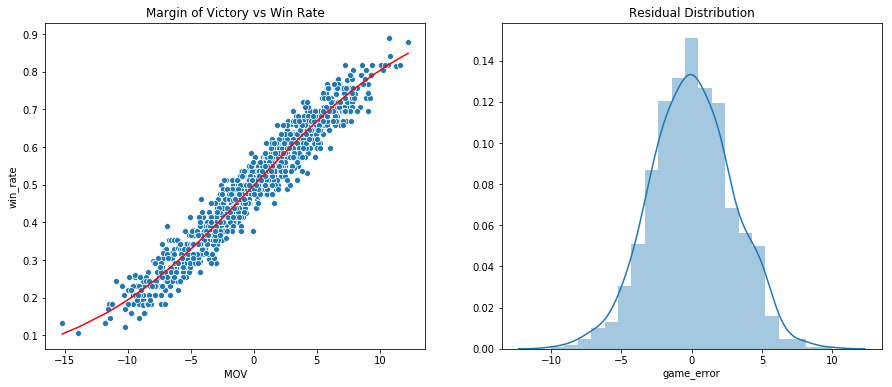

In [33]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.scatterplot(x = X['MOV'], y = y.apply(sigmoid))
sns.lineplot(x = X['MOV'], y = preds, color = 'red')
plt.title('Margin of Victory vs Win Rate')

plt.subplot(1,2,2)
sns.distplot(results['game_error'], bins = 21)
plt.title('Residual Distribution');

In [34]:
overachievers = results[results['playoff_wins'] >= 4].sort_values(by = 'error', ascending = False)
underachievers = results[np.array(results['MOV'] >= 0) & np.array(results['playoff_wins'] < 4)].sort_values(by = 'error')

In [35]:
overachievers.head(10)

,id,MOV,actual,prediction,error,wins,games,playoff_wins,playoff_games,predicted_wins,game_error
id,,,,,,,,,,,
GSW 1987,GSW 1987,-2.341463,0.512195,0.416712,0.095483,42,82,4,10,34,8
LAL 1995,LAL 1995,-0.219512,0.585366,0.491020,0.094346,48,82,5,10,40,8
NYK 1997,NYK 1997,3.121951,0.695122,0.607557,0.087565,57,82,6,10,50,7
PHO 1995,PHO 1995,3.878049,0.719512,0.632761,0.086751,59,82,6,10,52,7
CLE 2018,CLE 2018,0.939024,0.609756,0.531972,0.077784,50,82,12,22,44,6
PHI 1986,PHI 1986,2.353659,0.658537,0.581347,0.077190,54,82,6,12,48,6
PHI 1980,PHI 1980,4.219512,0.719512,0.643919,0.075593,59,82,12,18,53,6
DET 1989,DET 1989,5.804878,0.768293,0.693561,0.074731,63,82,15,17,57,6
BRK 2014,BRK 2014,-1.000000,0.536585,0.463464,0.073121,44,82,5,12,38,6


In [36]:
underachievers.head(10)

,id,MOV,actual,prediction,error,wins,games,playoff_wins,playoff_games,predicted_wins,game_error
id,,,,,,,,,,,
MIN 2014,MIN 2014,2.670732,0.487805,0.592229,-0.104424,40,82,0,0,49,-9
DAL 2020,DAL 2020,6.044776,0.597015,0.700731,-0.103716,40,67,0,0,47,-7
DET 1998,DET 1998,1.573171,0.451220,0.554242,-0.103023,37,82,0,0,45,-8
TOR 2008,TOR 2008,2.902439,0.500000,0.600124,-0.100124,41,82,1,5,49,-8
POR 1995,POR 1995,3.817073,0.536585,0.630753,-0.094168,44,82,0,3,52,-8
MIA 1994,MIA 1994,2.670732,0.512195,0.592229,-0.080033,42,82,2,5,49,-7
IND 1992,IND 1992,1.890244,0.487805,0.565302,-0.077497,40,82,0,3,46,-6
POR 1989,POR 1989,1.463415,0.475610,0.550401,-0.074791,39,82,0,3,45,-6
UTA 2016,UTA 2016,1.792683,0.487805,0.561905,-0.074101,40,82,0,0,46,-6


finally lets see how the 1993 Mavs stack up with the new model

In [57]:
sigmoid(fit.predict([-15.195122, 1]))[0] * 82

8.511501487648385

In [58]:
# much closer to their 11 wins

In [73]:
gsw_1987 = Schedule('GSW', year = 1987).dataframe

gsw_1987['MOV'] = [points - opp_points for points, opp_points in zip(gsw_1987['points_scored'], gsw_1987['points_allowed'])]

In [74]:
gsw_1987[np.array(gsw_1987['MOV'] > 0) & np.array(gsw_1987['MOV'] <= 6)].shape

(20, 16)

In [75]:
gsw_1987[gsw_1987['MOV'] <= -10].shape

(30, 16)

In [76]:
gsw_1987[np.array(gsw_1987['MOV'] < 0) & np.array(gsw_1987['MOV'] >= -6)].shape

(12, 16)

In [77]:
min_2014 = Schedule('MIN', year = 2014).dataframe

min_2014['MOV'] = [points - opp_points for points, opp_points in zip(min_2014['points_scored'], min_2014['points_allowed'])]

In [96]:
min_2014[np.array(min_2014['MOV'] < 0) & np.array(min_2014['MOV'] >= -9)].shape

(24, 16)

In [97]:
min_2014[np.array(min_2014['MOV'] > 0) & np.array(min_2014['MOV'] <= 9)].shape

(14, 16)

In [95]:
min_2014[min_2014['MOV'] >= 10].shape

(26, 16)